In [1]:
import os
import json
from glob import glob
from matplotlib.colors import ListedColormap
import numpy as np
import tifffile
from FSD.utils import extract_data, visualize, invert_one_hot
from FSD.fsd import process, reconstruct_label_mask

### Download Data

Images and corresponding instance segmentations (all of type `*.tif`) should be respectively present in sub-directories `images` and `masks`, which can be present at any location on your workstation, pointed to by the variables `data_dir` and `project_name`. 


In [2]:
data_dir = '../../../data'
project_name = 'BBBC020'

For the `BBBC020` dataset, we firstly download the data from an external url in the following cell.


In [3]:
# extract_data(
#     zip_url = 'https://github.com/lmanan/FSD/releases/download/v0.0.1/BBBC020.zip',
#     data_dir = data_dir,
#     project_name = project_name,
# )

### Investigate some of these images and corresponding instance segmentation masks

Load a `glasbey` style color map

In [4]:
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

In [5]:
%matplotlib inline
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'download', 'images','*.TIF')))
mask_file_names = sorted(glob(os.path.join(data_dir, project_name, 'download', 'masks','*.tif')))

Change the `index` parameter to visualize other images and masks. There are, in total, $20$ images and corresponding masks.

Image filename is jw-24h 1_c1.TIF and index is 10


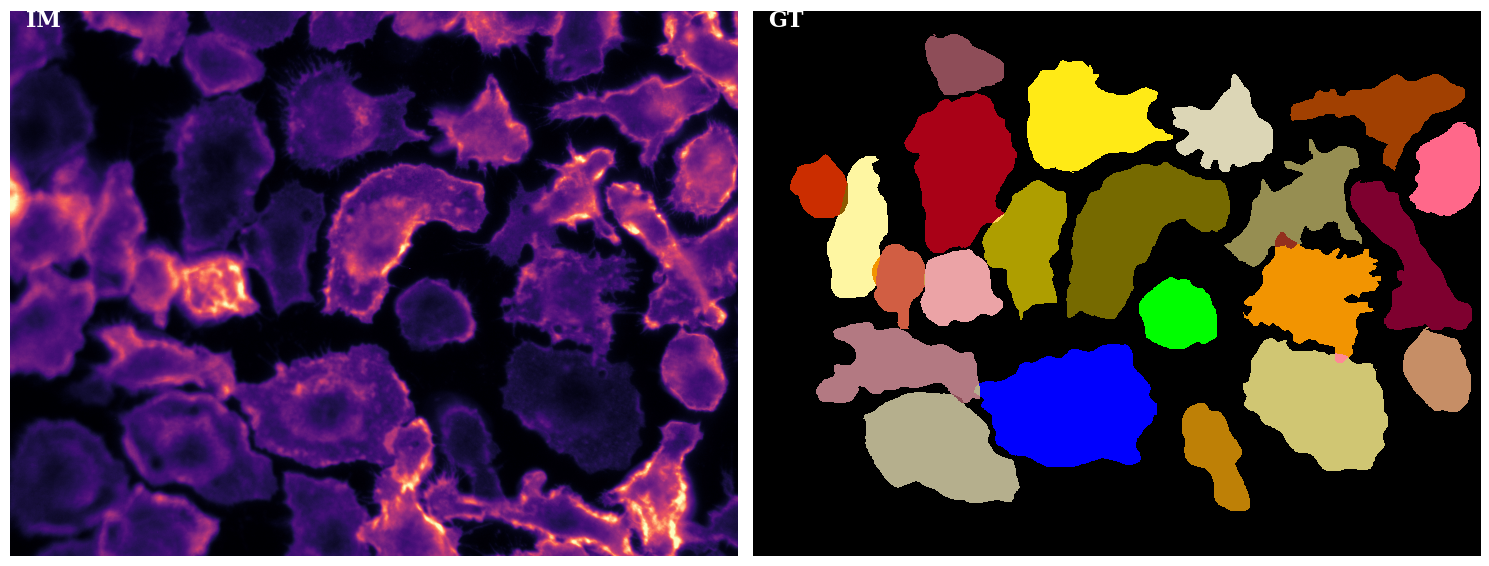

In [6]:
index = 10
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
image = tifffile.imread(image_file_names[index])
label_mask = tifffile.imread(mask_file_names[index])
visualize(image = image, ground_truth = invert_one_hot(label_mask), new_cmp = new_cmp)


### Convert shapes to Fourier Shape Descriptor (FSD) representations

We would like to study if there are any classes of diverse morphologies in this data-set. The task is to develop an analysis pipeline to retrieve and quantitatively characterize these morphology groups. <br>For this purpose, we use the `Fourier Shape Descriptor (FSD)` representation. This shape representation is obtained by going around the contour of each object one pixel at a time, storing the x and y coordinates of these boundary pixels, then performing a fourier analysis and finally investigating the obtained fourier coefficients. 

We process the complete available dataset through the `process` function. The frequency contributions are saved in the directory provided by the variable `fsd_dir_name`.

In [7]:
fsd_dir_name = 'fsd/'

In [8]:
process(dir_name= os.path.join(data_dir, project_name, 'download'), fsd_dir_name = fsd_dir_name)

100%|███████████████████████████████████████████| 20/20 [03:24<00:00, 10.22s/it]


Now, that the frequency components are saved, we can investigate the fidelity of reconstruction for any arbitrary label mask. <br>
Change the `index` parameter multiple times, to visualize other images and masks. There are, in total, 20 images and corresponding masks.<br>
Adjust the number of frequencies (`num_frequencies`) you would like to consider while reconstructing the shape.

In [22]:
index = 2
num_frequencies = 30

Image filename is jw-15min 3_c1.TIF and index is 2


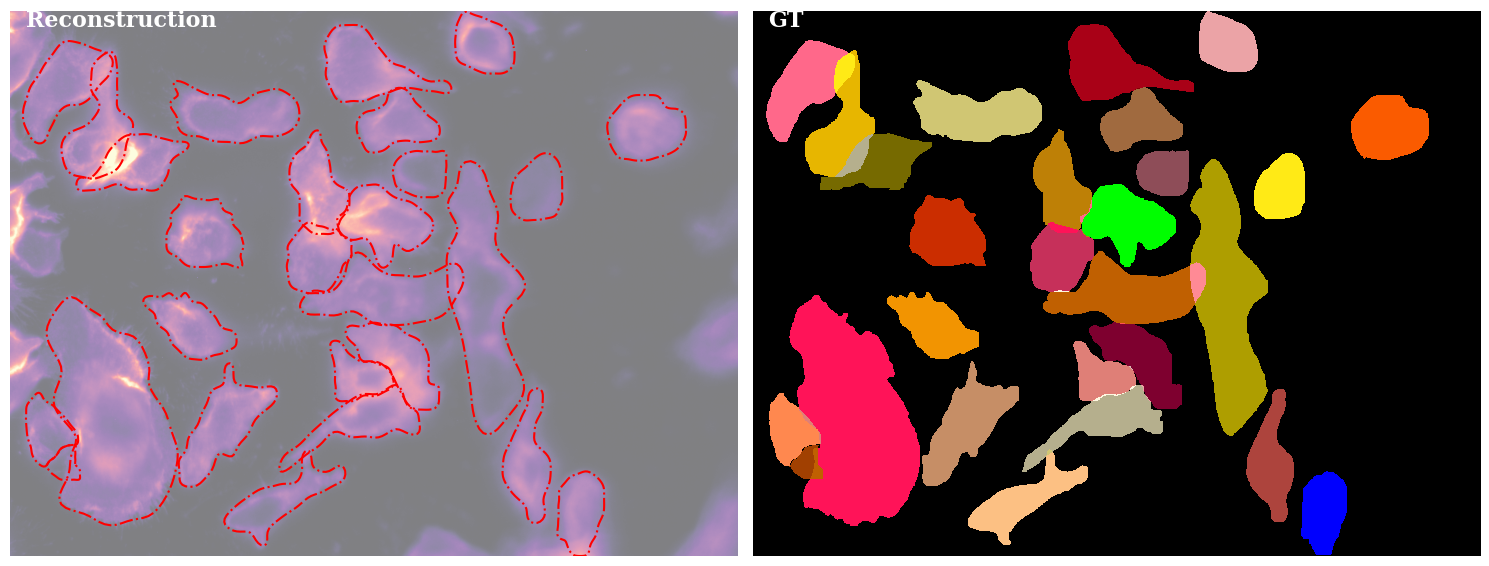

In [23]:
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
%matplotlib inline
reconstruct_label_mask(im_path = image_file_names[index], 
                       label_path = mask_file_names[index], 
                       fsd_dir_name= os.path.join(data_dir, project_name, 'download', fsd_dir_name), 
                       num_frequencies= num_frequencies, new_cmp = new_cmp)

### Clustering in the frequency space

Now that I am happy with the obtained reconstructions, I wonder whether I can identify individual morphologies in this dataset by clustering using a shape representation - a vector of size `num_frequencies`. <br>
Here, the first frequency contribution is like a `DC` contribution which just encodes the position of that object. <br>
Since, we would like the shape representation to be translation invariant, we do not use the first frequency contribution for identifying unique clusters.

In [26]:
import pandas as pd

In [27]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")

In [28]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [31]:
np.unique(penguins['species'])

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)